# Time Series and Longitudinal Data Tutorial
### Cecilia Cavero-Sanchez

**Data description**

International relations scholarship on intrastate peace and conflict largely conceptualizes peace as an absence of war and, to some extent, the presence of a minimal degree of democracy. Empirically, scholars treat peace as a non-event, identifying it as the absence of military battles rather than the presence of conflict-mitigating institutions or activities. Campbell et al (2020) operationalize an expanded conceptualization of peace through a latent variable measurement approach that carefully aggregates both conflict and cooperation events in Colombia for the period of 1993 to 2012.

- The data includes a latent measure of peace built upon two latent measures of conflict and cooperation, published by Campbell et al. (2020) for all Colombian municipalities from 1993 to 2012.
- The measures are created using the The Integrated Conflict Early Warning System's (ICEWS) Goldstein scale for conflict and cooperation among various parties.
- The authors apply the Bayesian Item-Response Theory (IRT) approach (Armstrong
et al. 2014).
- For the cooperation latent variable, they regress the counts of cooperative and neutral events—neutral events (intensity: 0); low cooperation events (intensity: 1 to 4); moderate-cooperation events (intensity: 5 to 6), and high-cooperation events (intensity: 7 to 10)—on the cooperation latent variable.
- For the conflict latent variable, they regress the counts of hostile and neutral events—high-hostility events (intensity: -10 to -8); moderate-hostility events (intensity: -7 to -4); low-hostility events (intensity: -3 to -1); neutral events (intensity: 0)—separately on the conflict latent variable.
- They create a single peace latent variable using IRT by replacing the conflict and cooperation latent variables in the model with a single peace latent variable, thereby creating a measurement of peace that in
corporates the coexistence and coevolution of conflict and cooperation.
- All events—whether cooperative or hostile—are negatively related to the latent peace variable. This means that higher event counts, regardless of type, correspond to lower peace scores. True "positive peace" may manifest as an absence of notable events, whether violent or cooperative. In peaceful contexts, cooperation becomes normalized and unremarkable, while conflict is absent altogether. Municipalities that did not experience any events have much higher peace values than those that had either hostile or cooperative events.


**Sources:**

Armstrong, D.A., Bakker, R., Carroll, R., Hare, C., Poole, K.T., & Rosenthal, H. (2020). Analyzing Spatial Models of Choice and Judgment (2nd ed.). Chapman and Hall/CRC. https://doi.org/10.1201/9781315197609

Campbell, Susanna P., Michael G. Findley, and Kyosuke Kikuta. “An Ontology of Peace: Landscapes of Conflict and Cooperation with Application to Colombia.” International Studies Review 19, no. 1 (2017): 92–113. http://www.jstor.org/stable/26407938.

Campbell, Susanna P.; Findley, Michael G.; Kikuta, Kyosuke, 2017, "Replication Data for: An Ontology of Peace: Landscapes of Conflict and Cooperation with Application to Colombia", https://doi.org/10.7910/DVN/MNEYJ6, Harvard Dataverse, V1

# Pip list

## Install libraries

First, we will install libraries necessary to run this analysis.

In [1]:
# Installing Libraries
!pip install pandas==2.2.2
!pip install matplotlib
!pip install geopandas
!pip install requests
!pip install zipfile
!pip install os
!pip install arch
!pip install pmdarima
!pip install sktime
!pip install tslearn

ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


## Upload data

Let's upload the dataset. These data are extracted from the replication data of the paper by Campbell et al. in the Harvard dataverse. I have uploaded them to my Github.

- The dataset contains nine variables: municipality (municipio), municipality code (codmpio), province (provincia), year (year), two measures of the median of the latent peace measure (peace1.m and peace2.m), the lower bounds of the latent measure (peace1.l and peace2.l), and the upper bounds of the latent measure (peace1.u and peace2.u).
- We will be using the peace1.m latent measure of peace.

In [2]:
 # Upload Data
import pandas as pd
url = 'https://raw.githubusercontent.com/ccaveros/Methods-Resources/main/Time-Series-Longitudinal-Data/peace_data.csv'
peace = pd.read_csv(url, encoding='latin-1')

# What do the data look like?
print(peace.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22440 entries, 0 to 22439
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   codmpio    22440 non-null  int64  
 1   year       22440 non-null  int64  
 2   peace1.m   22440 non-null  float64
 3   peace2.m   22440 non-null  float64
 4   peace1.l   22440 non-null  float64
 5   peace2.l   22440 non-null  float64
 6   peace1.u   22440 non-null  float64
 7   peace2.u   22440 non-null  float64
 8   municipio  22440 non-null  object 
 9   provincia  22360 non-null  object 
dtypes: float64(6), int64(2), object(2)
memory usage: 1.7+ MB
None


## Plot Data

Here we plot the data per municipality. That is, we have a time-series cross-sectional dataset, with over 1000 municipalities' latent measurement of peace over time. For ease of analysis, we will use these visualizations to choose three time series with different patterns for later analysis.


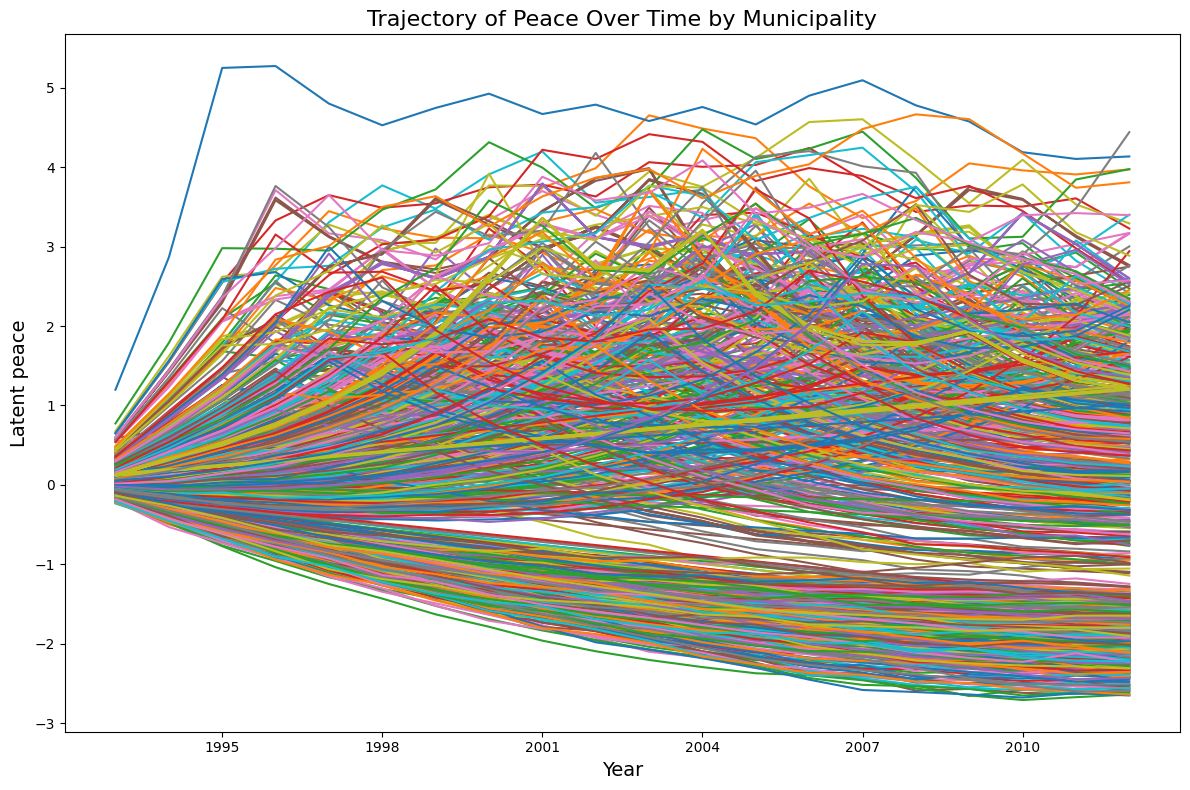

In [3]:
# Import library
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # to handle years in plot, adjust axis ticks

# Plot
plt.figure(figsize=(12, 8))  # Set figure size
for municipio, group in peace.groupby('municipio'): # group by unit
    plt.plot(group['year'], group['peace1.m'], label = municipio)

# Add title and labels
plt.title('Trajectory of Peace Over Time by Municipality', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Latent peace', fontsize = 14)

# Set x-axis to show integer years (otherwise years look weird, 2010.5)
ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.tight_layout() # Adjust layout to prevent clipping of the title

# Show the plot
plt.show()

## Map peace over time in Colombia
Before subsetting our data, let's see if we can map levels of peace over time. This is relevant when you want to detect spatial patterns of changes over times: which municipalities have a constant level of peace? Which change the most? Do we see geographical clustering in movement over time? To do this, we have to download the shapefile with the administrative boundaries of Colombia at the municipality level, merge the peace data per municipality-year, create one map per year, and create an animation using all the years' plots. We can use a function to do this.


In [4]:
## Map peace over time in Colombia
import geopandas as gpd # for maps
import requests # to import shapefiles
import zipfile # for import
import os # for import
from matplotlib.animation import FuncAnimation # for animation
from IPython.display import HTML # for animation
import matplotlib.pyplot as plt

# Download the shapefile (Colombia's administrative boundaries from DIVA-GIS)
url = "https://data.humdata.org/dataset/50ea7fee-f9af-45a7-8a52-abb9c790a0b6/resource/32fba556-0109-4d1c-84cb-c8abddf7775b/download/col-administrative-divisions-shapefiles.zip"  # DIVA-GIS Colombia shapefile URL
output_zip = "COL_adm.zip"
response = requests.get(url)
os.makedirs("COL_shapefile", exist_ok = True) # create the directory
print(os.listdir("COL_shapefile")) # check what the data structure looks like
with open(output_zip, "wb") as file:
    file.write(response.content)
with zipfile.ZipFile(output_zip, "r") as zip_ref:
    zip_ref.extractall("COL_shapefile") # extract shapefile
shapefile_path = "COL_shapefile/col_admbnda_adm2_mgn_20200416.shp"
colombia_gdf = gpd.read_file(shapefile_path) # load shapefile

# Inspect the GeoDataFrame
print(colombia_gdf.head()) # make sure data looks correct

# Remove whitespace on the left
minx, miny, maxx, maxy = -78, -5, -65, 15  # Bounding box: ADJUSTED minx

# Function to through the years to create maps
available_years = sorted(peace['year'].unique())  # Get all unique years
colombia_gdf_all_years = colombia_gdf.copy() # copy shapefile to modify leaving original intact
def update_map(year): # create one map per year
    global sm  # colorbar ScalarMappable (ensure one legend, otherwise many created)

    # Filter peace for the current year
    peace_data_year = peace[peace['year'] == year]

    # Merge peace into the GeoDataFrame
    colombia_gdf_year = colombia_gdf.merge(
        peace_data_year,
        left_on = 'ADM2_ES',  # Column in shapefile for municipality names
        right_on = 'municipio',  # Column in peace data for municipality names
        how = 'left'  # Keep all geom
    )

    # Clear axis for visual appeal
    ax.clear()

    # Plot base map (Colombia's administrative boundaries)
    colombia_gdf.plot(
        ax = ax,
        edgecolor = 'black',
        facecolor = 'none',  # Make the polygons transparent
        linewidth = 0.2 #boundary width
    )

    # Overlay peace
    colombia_gdf_year.plot(
        column = 'peace1.m',  # Column with peace levels
        cmap = 'Blues_r',  # blue colormap, reversed for lighter higher values
        linewidth = 0.8,
        ax = ax,
        edgecolor = 'none',
        legend = False, #prevent drawing legend twice
        missing_kwds = {  # handle NAs
            "color": "lightgray",  # municipalities without peace data to light gray
            "edgecolor": "none",   # no edgecolor for missing values
        }
    )

    # set axis limits
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # title and remove axis labels
    ax.set_title(f"Peace Levels in Colombia - {year}", fontsize = 12) # Reduced font size of title
    ax.set_axis_off()

    # legend -- this was very messy to figure out, I used Perplexity AI to help make the legend legible + right size
    if sm is None:
        sm = plt.cm.ScalarMappable(cmap = "Blues_r",
                                   norm = plt.Normalize(vmin = peace['peace1.m'].min(),
                                                        vmax = peace['peace1.m'].max()))
        sm._A = []  # dummy array for ScalarMappable
        cbar = fig.colorbar(sm, ax = ax, orientation = "vertical", fraction = 0.03,
                            pad = 0.04)
        cbar.set_label("Peace Level", fontsize = 10) # reduced fontsize of label

# Animation
fig, ax = plt.subplots(1, 1, figsize=(8, 6)) #reduced size because it was too big
sm = None  # ScalarMappable for colorbar
ani = FuncAnimation(fig, update_map, frames = available_years, interval = 1000,
                    repeat = False)
plt.close(fig)  # Close the static figure
HTML(ani.to_jshtml())

['col_admbnda_adm2_mgn_20200416.sbx', 'col_admbnda_adm2_mgn_20200416.shp', 'col_admbnda_adm2_mgn_20200416.cpg', 'col_admbndt_adminUnitLookup.cpg', 'col_admbndl_admALL_mgn_itos_20200416.sbn', 'col_admbndp_admALL_mgn_itos_20200416.shp.xml', 'col_admbnda_adm0_mgn_itos_20200416.sbx', 'col_admbnda_adm0_mgn_itos_20200416.shp', 'col_admbndp_admALL_mgn_itos_20200416.shp', 'col_admbnda_adm1_mgn_20200416.sbn', 'col_admbndl_admALL_mgn_itos_20200416.shp', 'col_admbnda_adm1_mgn_20200416.dbf', 'col_admbnda_adm2_mgn_20200416.dbf', 'COL COD-AB 2020_04_24.pdf', 'Shapefiles.zip', 'col_admbnda_adm1_mgn_20200416.shx', 'col_admbnda_adm2_mgn_20200416.prj', 'col_admbndl_admALL_mgn_itos_20200416.dbf', 'col_admbndl_admALL_mgn_itos_20200416.cpg', 'col_admbndp_admALL_mgn_itos_20200416.shx', 'col_admbndp_admALL_mgn_itos_20200416.sbx', 'col_admbndt_adminUnitLookup.dbf', 'col_admbnda_adm0_mgn_itos_20200416.dbf', 'col_admbndp_admALL_mgn_itos_20200416.prj', 'col_admbndp_admALL_mgn_itos_20200416.cpg', 'col_admbndp_adm

## Subset data and turning into time series
For time series analysis, let's pick out three series for municipalities to compare their peace trajectories over time. I want to pick one municipality with a high level of peace, one with a low level of peace, and one that follows a middle trajectory. Then we can visualize the three municipalities I picked out to check how they vary over time.

          municipio  average_peace1.m
130            Cali          4.435726
152       Cartagena          3.468385
1011  Villavicencio          3.412790
108    Buenaventura          3.372409
83     Barranquilla          3.369858
                   municipio  average_peace1.m
265  El Cantón del San Pablo         -1.762674
516                  Matanza         -1.767301
610                 Pamplona         -1.782908
342                  Gamarra         -1.810296
302                El Águila         -1.880027
         municipio  average_peace1.m
1006  Villahermosa          1.020218
480     Los Patios          1.016882
989      Venadillo          1.015411
252          Dagua          1.007653
1010    Villarrica          1.004899
       codmpio  year  peace1.m  peace2.m  peace1.l  peace2.l  peace1.u  \
19580    73861  1993  0.090924 -0.297241 -0.900392 -1.984479  1.151244   
19581    73861  1994  0.219518 -0.453505 -1.176301 -2.298221  1.569769   
19582    73861  1995  0.383787 -0.519050 -1.14

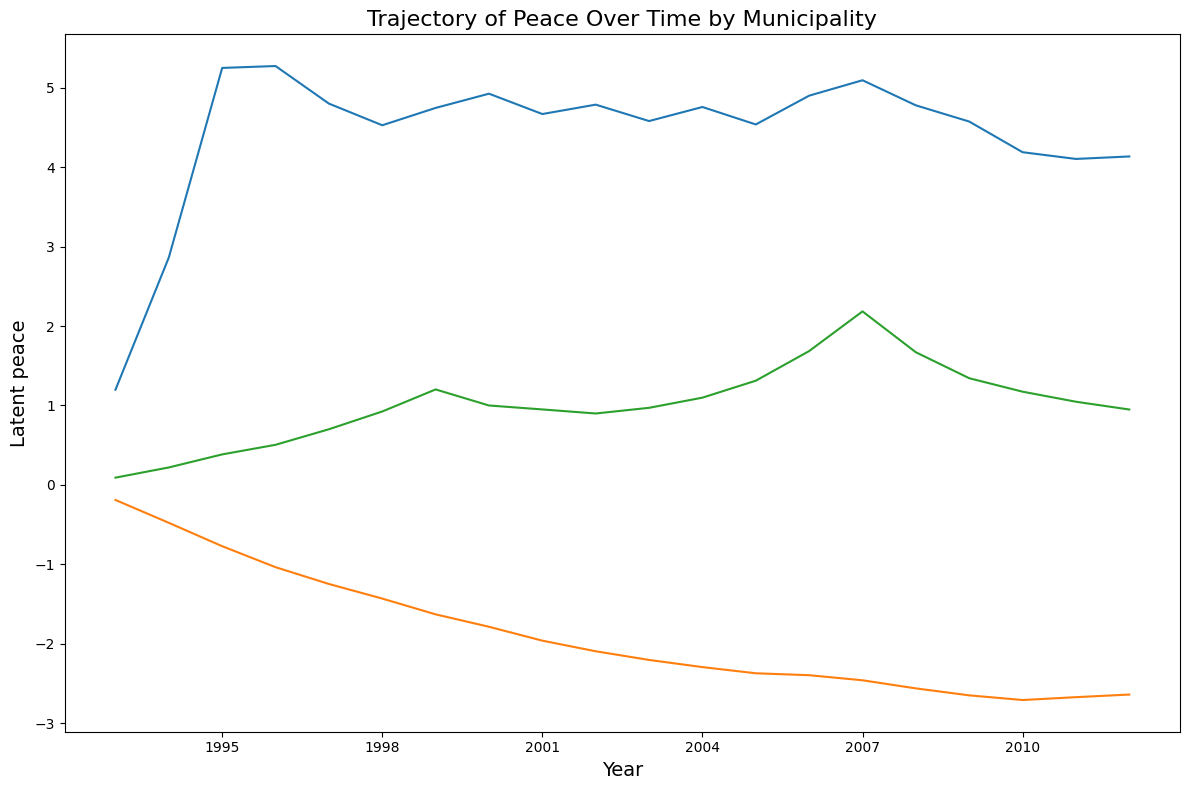

In [5]:
## Let's pick municipalities with different trajectories
# Calculate the average peace1.m for each municipality
average_peace = peace.groupby('municipio')['peace1.m'].mean().reset_index()
average_peace = average_peace.rename(columns = {'peace1.m': 'average_peace1.m'}) # rename for clarity

# Get most peaceful, least peaceful, and middle of peaceful
sorted_peace = average_peace.sort_values(by = 'average_peace1.m', ascending = False)
most_peaceful = sorted_peace.head()
print(most_peaceful) # Cali
least_peaceful = sorted_peace.tail()
print(least_peaceful) # El Águila
avg_above_zero = sorted_peace[sorted_peace['average_peace1.m'] > 1] # median had a very similar trajectory
# so i picked out one municipality with a value above 1 to get a different trajectory
print(avg_above_zero.tail()) # Venadillo

## Subset to three main municipalities
municipalities = ['Cali', 'El Águila', 'Venadillo'] # create vector municipality names we want
peace_filtered = peace[peace['municipio'].isin(municipalities)] # subset

# Check data
print(peace_filtered.head()) # make sure it looks right

# Plot again
plt.figure(figsize = (12, 8))  # Set figure size
for municipio, group in peace_filtered.groupby('municipio'):
    plt.plot(group['year'], group['peace1.m'], label = municipio)

# title and labels
plt.title('Trajectory of Peace Over Time by Municipality', fontsize = 16)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Latent peace', fontsize = 14)

# set x-axis again for years to look right
ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer = True))
plt.tight_layout()
plt.show() # display plot

## Turn data into time series
To turn our data into a time series object, we need to make sure we have a date variable -- in this case, year, and then we can tell Python to use that date to create an object that is a time series.

In [6]:
# Turn into time series
peace_filtered['year'] = pd.to_datetime(peace_filtered['year'], format = '%Y') # format year
peace_filtered.set_index(['municipio', 'year'], inplace = True)
peace_filtered.sort_index(inplace = True)
print(peace_filtered)
print(peace_filtered.index.get_level_values('municipio').unique())  # Accessing 'municipio' from the index

                      codmpio  peace1.m  peace2.m  peace1.l  peace2.l  \
municipio year                                                          
Cali      1993-01-01    76001  1.198380  2.361600  0.166977  1.196600   
          1994-01-01    76001  2.864130  3.304085  1.793404  2.190171   
          1995-01-01    76001  5.251040  4.466705  3.791704  3.407185   
          1996-01-01    76001  5.274805  4.812905  3.827735  3.703833   
          1997-01-01    76001  4.801620  4.661015  3.449092  3.545263   
          1998-01-01    76001  4.528920  4.576765  3.239975  3.453017   
          1999-01-01    76001  4.747225  4.488565  3.415052  3.411017   
          2000-01-01    76001  4.926565  4.480025  3.611333  3.438559   
          2001-01-01    76001  4.670305  4.259425  3.350594  3.129529   
          2002-01-01    76001  4.788655  4.086870  3.473433  3.049035   
          2003-01-01    76001  4.581790  3.934745  3.348825  2.912622   
          2004-01-01    76001  4.758985  3.998685  

<ipython-input-6-89c51de00af5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peace_filtered['year'] = pd.to_datetime(peace_filtered['year'], format = '%Y') # format year
<ipython-input-6-89c51de00af5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peace_filtered.sort_index(inplace = True)


## ACF and PACF
The autocorrelation function (ACF) and partial ACF (PACF) are important tools to identify patterns and model selection. We want to understand our time series better.  The ACF measures the correlation between a time series and its lagged values at different time points. The PACF measures the correlation between a time series and its lagged values while controlling for the effects of intermediate lags. PACFs are useful because they show the direct relationship between an observation and its lag without the influence of other lags. Let's create a function and visualize the ACF and PACF for our three time series.

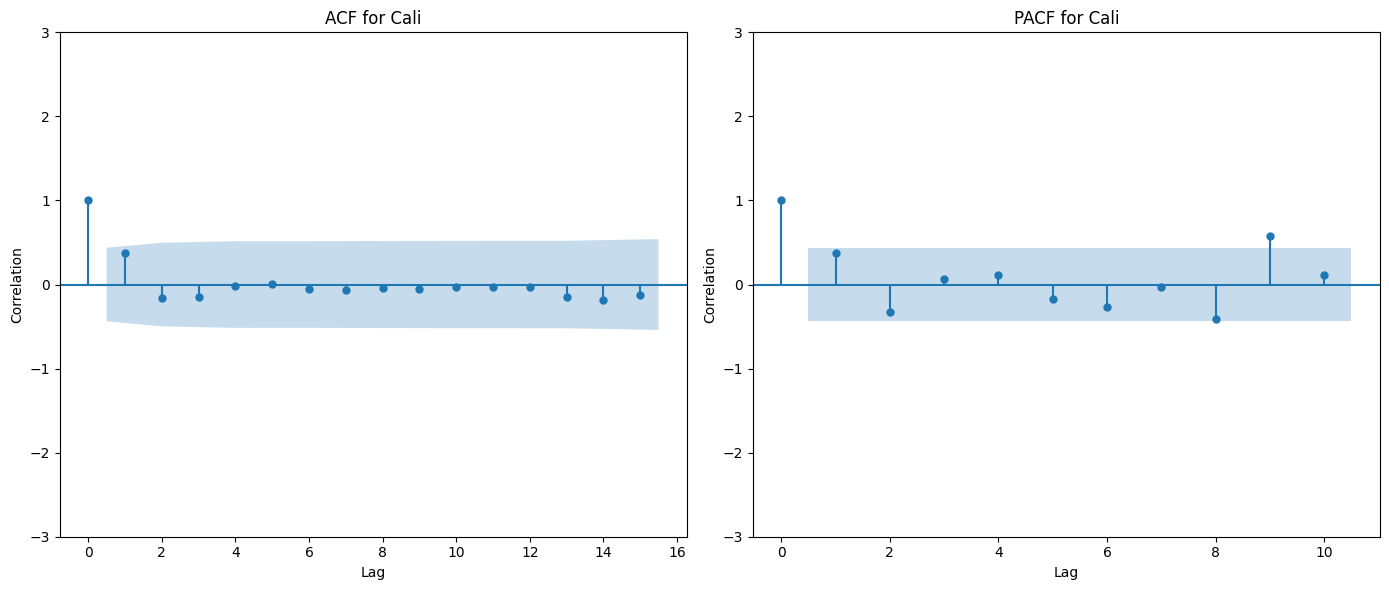

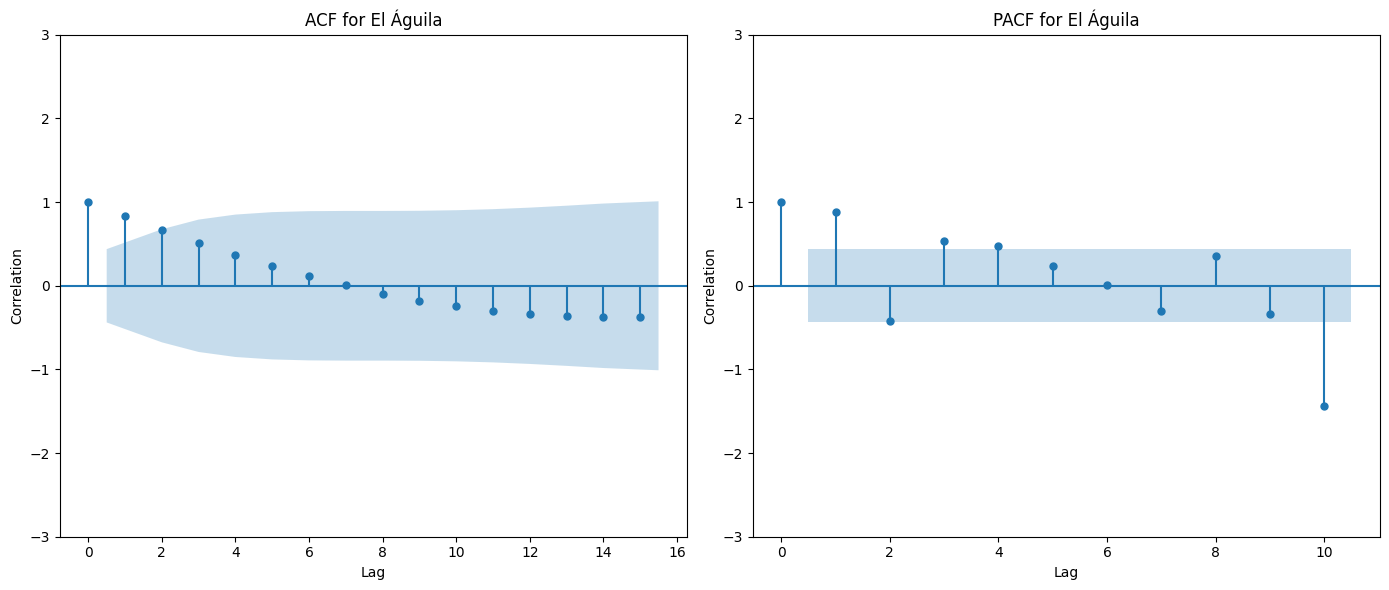

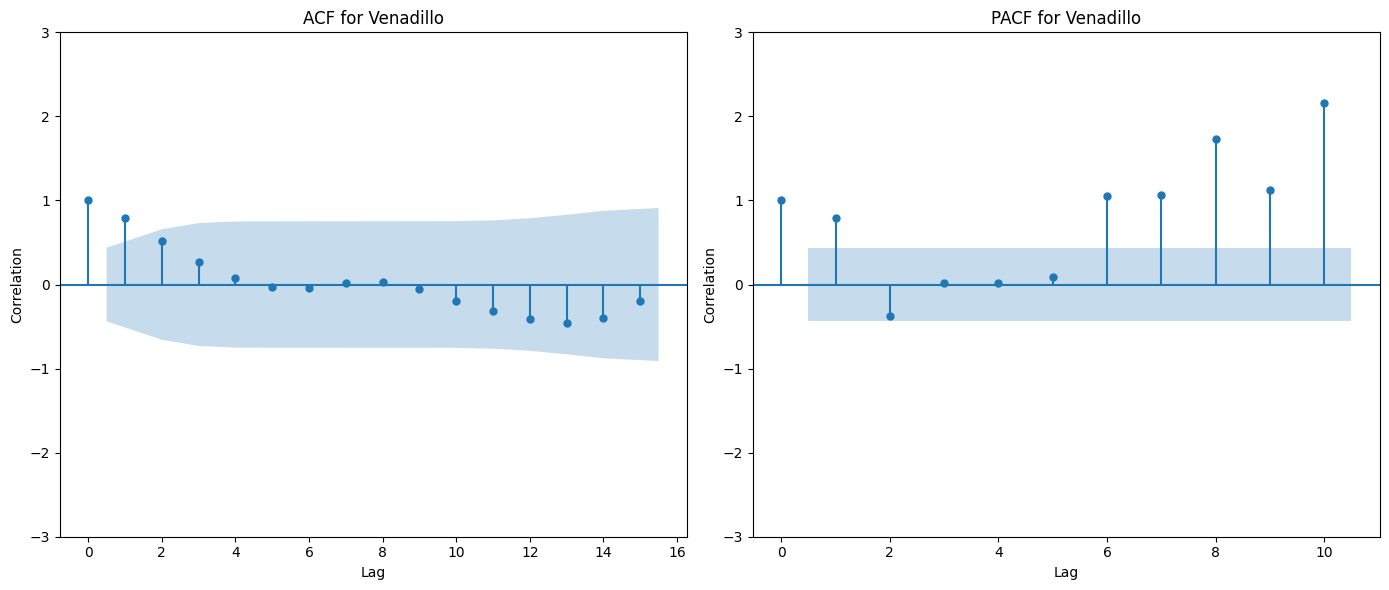

In [7]:
## ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Function to plot ACF and PACF and perform ADF test
def plot_acf_pacf(municipality_name, data):
    municipality_data = data.loc[municipality_name]['peace1.m'] # loc to select all data for the unit

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    plot_acf(municipality_data, ax=axes[0], title=f'ACF for {municipality_name}', lags=15)
    plot_pacf(municipality_data, ax=axes[1], title=f'PACF for {municipality_name}',
              method='ols', lags=10) # cannot do more than half the sample

    for ax in axes:
      ax.set_ylim(-3, 3)
      ax.set_xlabel('Lag')
      ax.set_ylabel('Correlation')

    plt.tight_layout()
    plt.show()

# Get unique municipality names
municipalities = peace_filtered.index.get_level_values('municipio').unique().tolist()

# Apply the function to each municipality
for municipio in municipalities:
    plot_acf_pacf(municipio, peace_filtered)


## Time series decomposition
Now that we have our data as a time series, let's decompose it to observe trends, seasonality, and residuals. Since we have three time series (remember, three municipalities we picked out), I create a function to make the code more efficient.

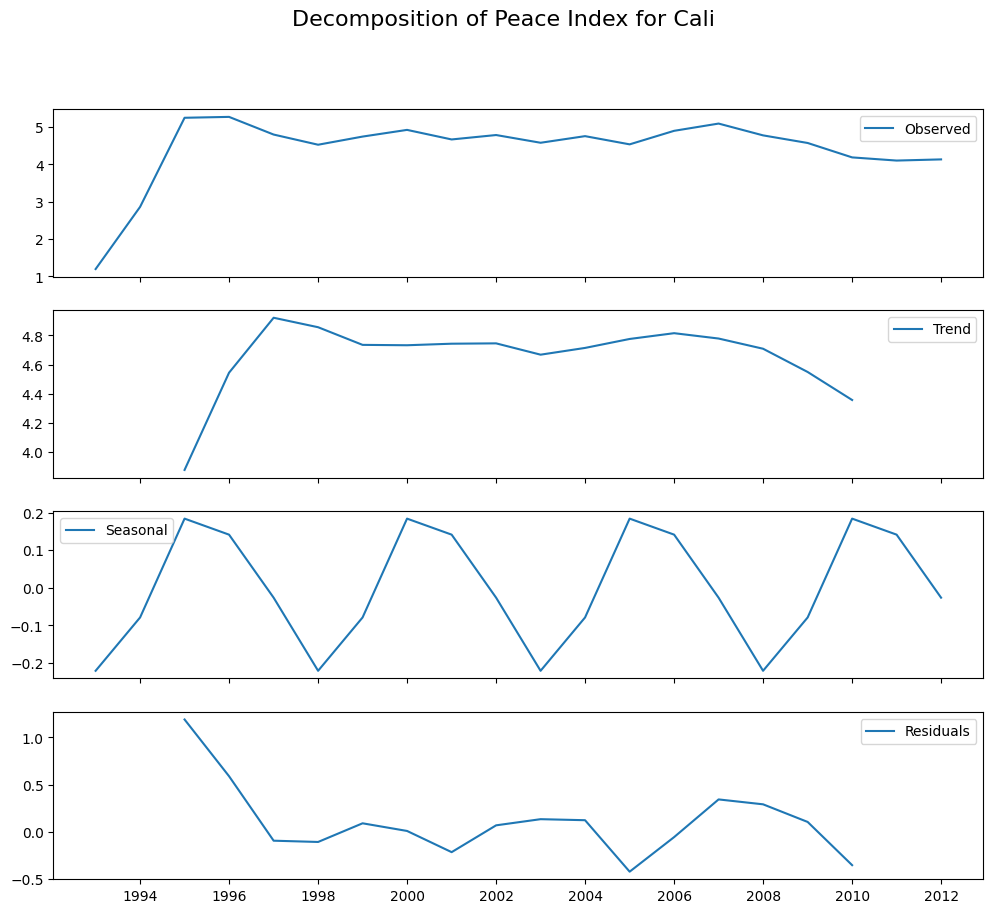

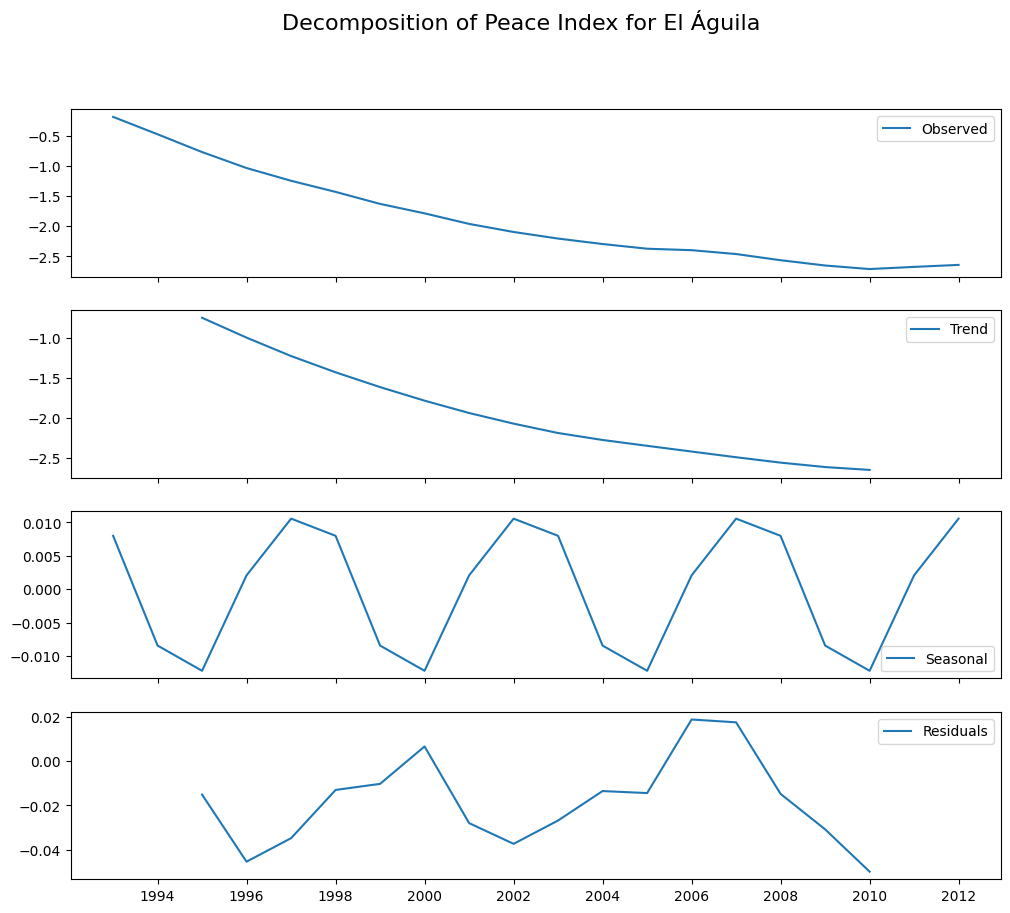

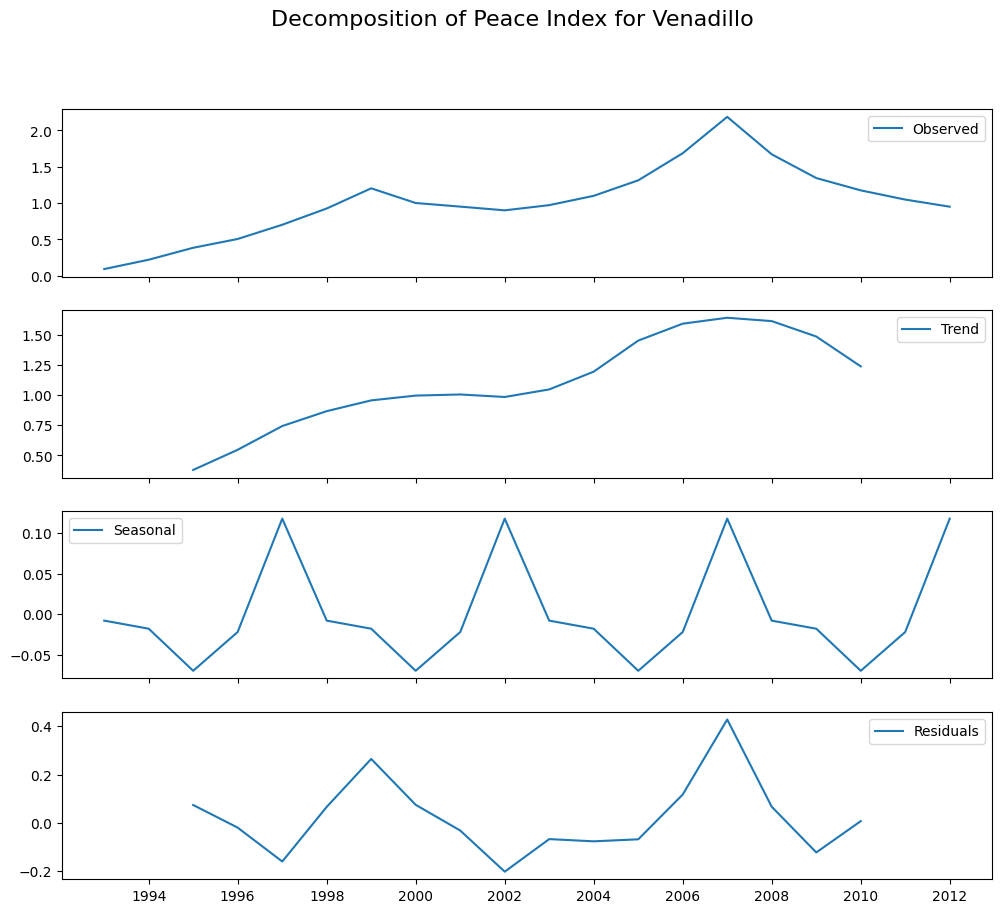

In [8]:
## Time Series Decomposition
# Import libraries
from statsmodels.tsa.seasonal import seasonal_decompose

# Function to plot decomposition for each municipality
def plot_decomposition(municipality_name, data):
    # municipality data
    municipality_data = data.loc[municipality_name]['peace1.m'] # get unit

    # decomposition
    decomposition = seasonal_decompose(municipality_data,
                                       model = 'additive', # additive seasonal component, e.g. not multiplicative
                                       period = 5) # since ACF and PACF show cyclical patterns in some cases

    # plot
    fig, axes = plt.subplots(4, 1, sharex = True, figsize = (12, 10)) # plot sizing

    axes[0].plot(decomposition.observed, label = 'Observed')
    axes[0].legend()

    axes[1].plot(decomposition.trend, label = 'Trend')
    axes[1].legend()

    axes[2].plot(decomposition.seasonal, label = 'Seasonal')
    axes[2].legend()

    axes[3].plot(decomposition.resid, label = 'Residuals')
    axes[3].legend()

    plt.suptitle(f'Decomposition of Peace Index for {municipality_name}',
                 fontsize = 16)
    plt.show()

# decompose ts
municipalities = peace_filtered.index.get_level_values('municipio').unique().tolist() # Get unique municipality names from the index
for municipio in municipalities:
    plot_decomposition(municipio, peace_filtered)

We can see that all series are trending, some more clearly than others. The first series has a sharp increase at the beginning that later stabilizes, the second series follows a downward trend, and the third one has a gradual increase in peace over time, with a few shocks.

## Test for stationarity

Stationarity is a key concept in time series; a stationary process is a time series whose properties do not change over time. That is, they have a constant mean, variance, and covariance that does not depend on the time we pick out -- it just depends on the number of lags. Since the statistical properties of stationary processes don't vary over time, this means we can use conventional statistical analysis with stationary time series. If a series is non-stationary, we have to account for its non-stationary components to conduct meaningful inference (e.g. appropriate test distributions, avoiding spurious regressions, among others).

**1. Deterministic trend:** $t$ increases or decreases as a function of time.

**2. Stochastic trend:** it differs from the deterministic trend in that the value added to each period is not fixed, but random, accumulating past shocks.

We need to account for these trends! We can use several testing strategies -- used in combination for more credibility. Some of these tests are the agumented Dickey-Fuller test, the Phillips-Perron test, and the KPSS test.

In [9]:
## Test stationarity
from statsmodels.tsa.stattools import adfuller, kpss # ADF and KPSS
from arch.unitroot import PhillipsPerron # pp test
from statsmodels.tsa.stattools import pacf

# function again to run the stationarity tests
def run_stationarity_tests(series):
    results = {}

    # ADF with automatic lag selection -- we could also select lags based on ACF and PACF
    adf_result = adfuller(series, autolag = 'AIC', regression = 'ct')
    results['ADF'] = {'statistic': adf_result[0], 'p-value': adf_result[1], 'lags': adf_result[2]}

    # KPSS
    kpss_result = kpss(series, regression = 'ct', nlags = 'auto') # same as above
    results['KPSS'] = {'statistic': kpss_result[0], 'p-value': kpss_result[1], 'lags': kpss_result[2]}

    # PP -- we cannot use atomatic lag selection here so use 10, as above
    pp = PhillipsPerron(series, trend = 'ct', lags = 10)
    results['PP'] = {'statistic': pp.stat, 'p-value': pp.pvalue, 'lags': pp.lags}
    return results


## output is complicated to understand, so let's create a function to write it out for us
def interpret_results(results):
    interpretations = []

    # ADF
    if results['ADF']['p-value'] <= 0.05: # reject the null of unit root (non-stationarity)
        interpretations.append("ADF Test: The series is likely stationary")
    else:
        interpretations.append("ADF Test: The series is likely non-stationary") # fail to reject null

    # KPSS
    if results['KPSS']['p-value'] <= 0.05:
        interpretations.append("KPSS Test: The series is likely non-stationary") # reject the null of unit root (non-stationarity)
    else:
        interpretations.append("KPSS Test: The series is likely stationary") # fail to reject null

    # PP
    if results['PP']['p-value'] <= 0.05:
        interpretations.append("PP Test: The series is likely stationary") # reject the null of unit root (non-stationarity)
    else:
        interpretations.append("PP Test: The series is likely non-stationary") # fail to reject null

    return interpretations

# Run tests for each municipality
for municipio in municipalities:
    print(f"\nResults for {municipio}:")
    municipality_data = peace_filtered.loc[municipio]['peace1.m'].dropna()

    results = run_stationarity_tests(municipality_data)

    for test, result in results.items():
        print(f"{test} Test - Statistic: {result['statistic']:.4f}, p-value: {result['p-value']:.4f}, Lags: {result['lags']}")

    interpretations = interpret_results(results)
    print("\nInterpretations:")
    for interp in interpretations:
        print(interp)



Results for Cali:
ADF Test - Statistic: -3.9559, p-value: 0.0101, Lags: 7
KPSS Test - Statistic: 0.1425, p-value: 0.0566, Lags: 1
PP Test - Statistic: -13.3023, p-value: 0.0000, Lags: 10

Interpretations:
ADF Test: The series is likely stationary
KPSS Test: The series is likely stationary
PP Test: The series is likely stationary

Results for El Águila:
ADF Test - Statistic: -2.9356, p-value: 0.1510, Lags: 7
KPSS Test - Statistic: 0.2056, p-value: 0.0139, Lags: 2
PP Test - Statistic: -2.6711, p-value: 0.2483, Lags: 10

Interpretations:
ADF Test: The series is likely non-stationary
KPSS Test: The series is likely non-stationary
PP Test: The series is likely non-stationary

Results for Venadillo:
ADF Test - Statistic: -0.5305, p-value: 0.9822, Lags: 7
KPSS Test - Statistic: 0.1201, p-value: 0.0979, Lags: 2
PP Test - Statistic: -0.1522, p-value: 0.9923, Lags: 10

Interpretations:
ADF Test: The series is likely non-stationary
KPSS Test: The series is likely stationary
PP Test: The series i

The last two series are likely non stationary even if we account for a trend and a constant. We might have a stochastic trend (case 2) and also structural breaks (case 3). Go up and check the observed series.

## Forecasting with ARIMA

Here I show the process of fitting ARIMA models to time series data to the three municipalities.

In [10]:
# Libraries
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore", category = FutureWarning) # remove warnings
warnings.filterwarnings("ignore", category = UserWarning) # also in seasonality

# Auto ARIMA modeling
def fit_auto_arima_model(municipality_name, data):

        # Fit Auto ARIMA model
        auto_model = pm.auto_arima(municipality_data,
                                   start_p=0, start_q=0,
                                   max_p=15, max_q=15, max_d=5,
                                   start_P=0, start_Q=0,
                                   max_P=2, max_Q=2, max_D=1,
                                   m=5,  # 5 year cycles
                                   seasonal=True,
                                   stepwise=True,
                                   suppress_warnings=True,
                                   error_action='ignore',
                                   trace = False)

        print(f"Best ARIMA order for {municipality_name}: {auto_model.order}")
        print(f"Best seasonal order: {auto_model.seasonal_order}")

        # Refit using SARIMAX for consistency
        best_order = auto_model.order
        best_seasonal_order = auto_model.seasonal_order
        model = SARIMAX(municipality_data, order=best_order, seasonal_order=best_seasonal_order)
        model_fit = model.fit()
        print(model_fit.summary())
        return model_fit


# Use
fitted_models = {}
for municipio in municipalities:
    model = fit_auto_arima_model(municipio, peace_filtered)
    if model:
        fitted_models[municipio] = model

Best ARIMA order for Cali: (2, 0, 0)
Best seasonal order: (2, 1, 0, 5)
                                     SARIMAX Results                                     
Dep. Variable:                          peace1.m   No. Observations:                   20
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 5)   Log Likelihood                  -3.531
Date:                           Sun, 16 Feb 2025   AIC                             17.062
Time:                                   15:33:05   BIC                             20.603
Sample:                               01-01-1993   HQIC                            17.025
                                    - 01-01-2012                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4032      0.476      2.948      0.

For all three municipalities, the auto_arima function selected the order ARIMA(2, 0, 0). There is a component of dependence on the previous two years on the value of peace.

Then, we have a seasonal component, measured at the 5 year interval, which should be included in the model given the data-driven selection, but are not significant. The Ljung-Box test shows there is no significant autocorrelation in the residuals, and the Jarque-Bera test indicates that the residuals are normally distributed.

## Predictions
Let's predict five years into the future for the first municipality.

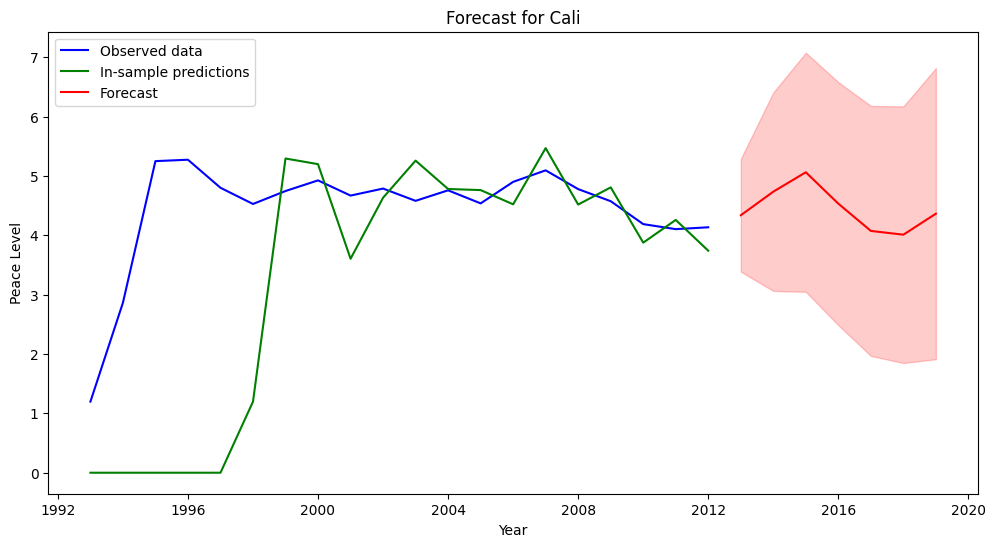

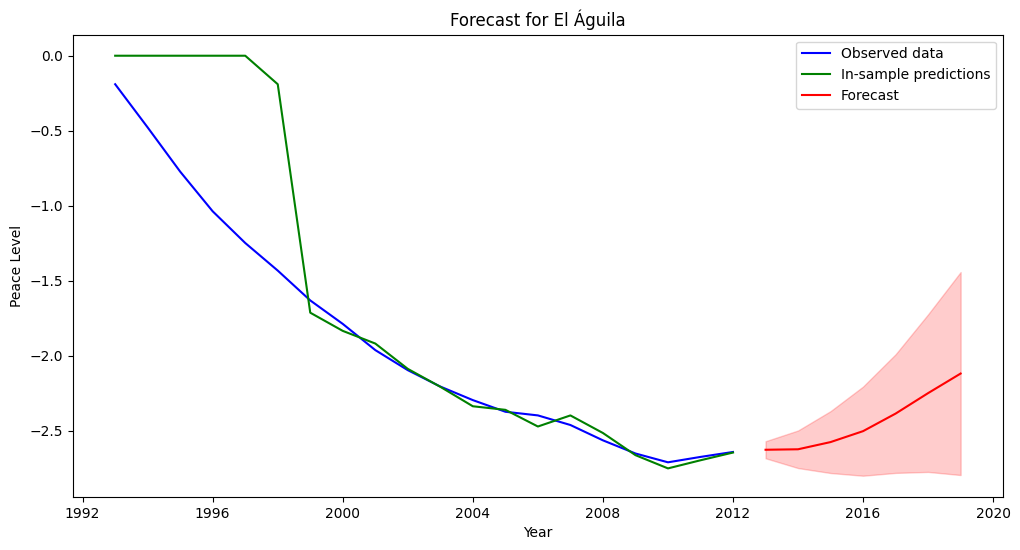

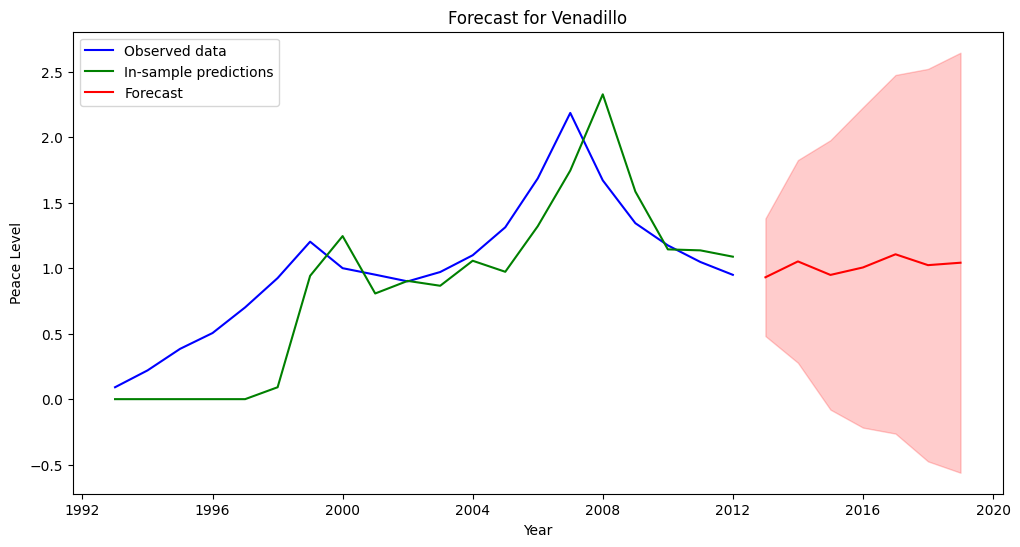

In [11]:
# Make predictions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Function
def plot_municipality_forecast(municipality_name, fitted_models,
                               peace_filtered, forecast_years):

    # Get fitted models
    model_fit = fitted_models[municipality_name]

    # Original data
    municipality_data = peace_filtered.loc[(municipality_name,), 'peace1.m']

    # Order and seasonal_order from fitted model
    model_order = model_fit.model.order
    model_seasonal_order = model_fit.model.seasonal_order

    # Refit model on full data
    model = SARIMAX(municipality_data, order=model_order,
                    seasonal_order=model_seasonal_order)
    model_fit = model.fit(disp=False)

    # Create a date index for the forecast period
    last_date = municipality_data.index[-1]
    forecast_index = pd.date_range(start=last_date,
                                   periods=forecast_years + 1,
                                   freq='YS-JAN')[1:]

    # Model fit in full data
    in_sample_predictions = model_fit.predict(start=municipality_data.index[0],
                                              end=municipality_data.index[-1])

    # Forecast into the future
    forecast = model_fit.get_forecast(steps=forecast_years)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # Determine the plotting range for model fit
    plot_index = municipality_data.index

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(municipality_data.index, municipality_data, label = 'Observed data', color = 'blue')
    plt.plot(plot_index, in_sample_predictions, label = 'In-sample predictions', color = 'green')
    plt.plot(forecast_index, forecast_mean, label = 'Forecast', color = 'red')

    # Confidence intervals
    plt.fill_between(forecast_index,
                     forecast_ci.iloc[:, 0],
                     forecast_ci.iloc[:, 1],
                     color='red', alpha=0.2)

    plt.title(f'Forecast for {municipality_name}')
    plt.xlabel('Year')
    plt.ylabel('Peace Level')
    plt.legend()
    plt.show()


# Use the plots
if fitted_models:
    for municipio in municipalities:
        plot_municipality_forecast(municipio, fitted_models, peace_filtered, 7)

## Clustering

Clustering is an unsupervised machine learning technique that aims to group similar data points together into clusters -- we use it to uncover natural groupings in data. We do not provide the algorithm any pre-defined categories (unsupervised!), it identifies the groups themselves based on data patterns.

- Main idea is to maximize similarity within clusters and minimize similarity between clusters.
- We need to choose a clustering algorithym, each has a different approach to what similarity means and how to create the cluster. Here, we are going to use K-means clustering which partitions data into k clusters, and each data point belongs to the cluster with the nearest mean. I choose the implementation TimeSeriesKMeans from the sktime library because it is adapted for time series by using Dynamic Time Warping as a distance metric.
- For peace levels, this is useful to identify common peace trajectories. Visual inspection above suggests there are several possible clusters that change with similar patterns over time.
- After uncovering the clusters, we could try to discover regional patterns in the levels of peace -- are closer municipalities similar in peace levels because of similar influences, such as economic conditions or armed group activity?
- Understanding general patterns in clusters might also help design peacebuilding interventions.


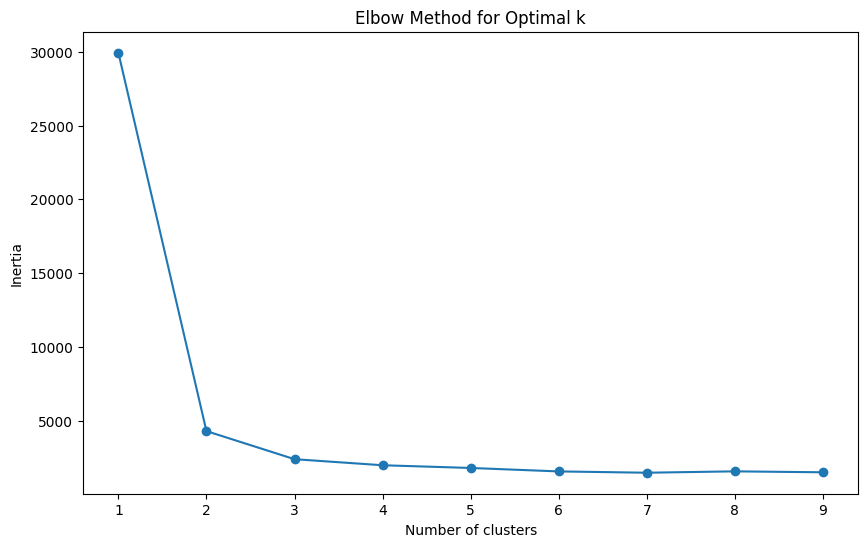

In [12]:
## Clustering
# Libraries

from sktime.clustering.k_means import TimeSeriesKMeans  # Updated import
from sktime.datasets import load_basic_motions
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Needed for numpy arrays

# Prepare data for clustering, needs to be in the sktime format
peace_clustering = peace.reset_index() # remove index to work with it

# Address duplicate entries
peace_clustering = peace_clustering.drop_duplicates(subset=['municipio', 'year'], keep='first')

# Pivot the DataFrame to have the correct format for clustering
peace_pivot = peace_clustering.pivot(index='municipio', columns='year', values='peace1.m')
peace_pivot = peace_pivot.dropna() # drop NAs from municipality time series to work

# Convert the pivoted DataFrame to the sktime format
# sktime requires a specific nested pandas DataFrame format for time series data
# We will use the 'numpy3D' format
peace_numpy = np.array([peace_pivot.loc[i].values for i in peace_pivot.index])

# Determine the optimal number of clusters using the Elbow Method
inertia = []
range_values = range(1, min(10, len(peace_pivot))) # try up to 10 clusters or the number of time series, whichever is smaller
for n_clusters in range_values:
    kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
    kmeans.fit(peace_numpy)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


Now we select the clusters. As we can see from the plots below, they do seem to follow clearly different trajectories!

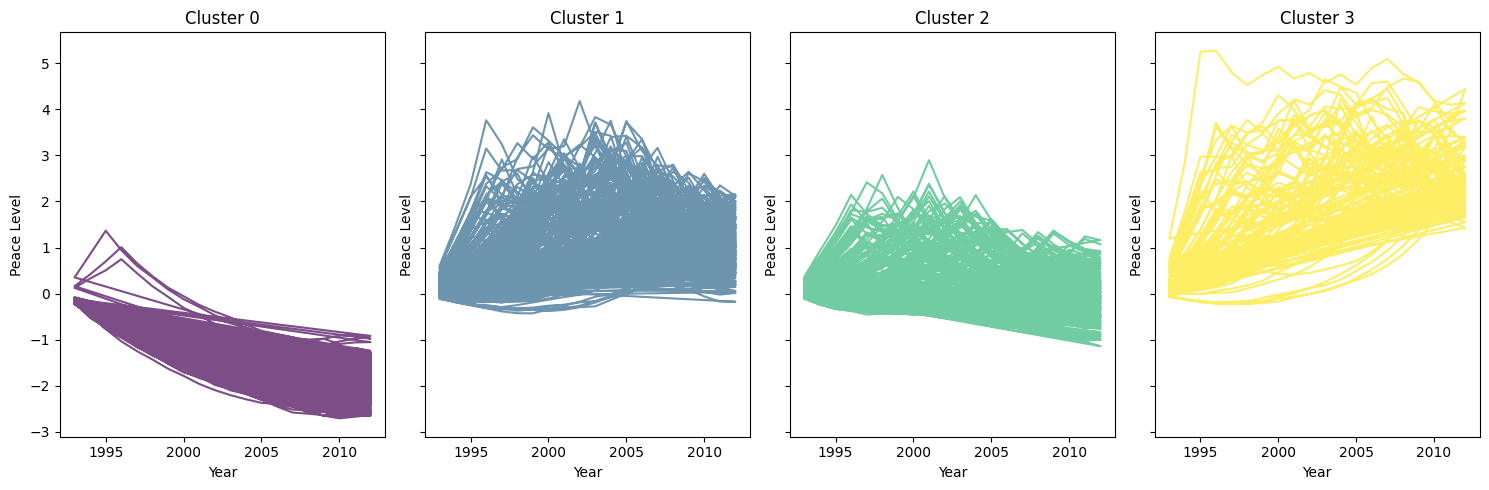

In [21]:
# Select clusters and plot
from tslearn.clustering import TimeSeriesKMeans

# prep data
peace = peace.drop_duplicates(['municipio', 'year'], keep='first')
peace_pivot = peace.pivot(index='municipio', columns='year', values='peace1.m').dropna()
peace_numpy = np.array([peace_pivot.loc[i].values for i in peace_pivot.index])

# clustering
n_clusters = 4
kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0, n_init=5) # initialize
cluster_labels = kmeans.fit_predict(peace_numpy) # predict clusters

# cluster labels added to data
peace_pivot['Cluster'] = cluster_labels
peace['Cluster'] = peace.municipio.map(peace_pivot['Cluster'])

# plot
fig, axes = plt.subplots(1, n_clusters, figsize=(15, 5), sharex=True, sharey=True) # plot in subplots
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters)) # one color per cluster

for i in range(n_clusters):
    cluster_data = peace[peace['Cluster'] == i]
    axes[i].plot(cluster_data['year'], cluster_data['peace1.m'], color=colors[i], alpha=0.7)
    axes[i].set_title(f'Cluster {i}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Peace Level')

plt.tight_layout()
plt.show()

From these plots above we can see that we should be most concerned about the municipalities from the first cluster, as they show a declining trend in peace levels over time. The third cluster also shows a slight decrease in peace levels over time, though less pronounced. Meanwhile, the fourth clsuter shows increasing levels of peace over time -- these should not be the focus of peacebuilding programs. The second cluster shows a stagnant pattern, with peace remaining relatively stable after an initial period of increase for some municipalities.